In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 28 14:28:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |    221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

**Тестова задача.**

Домен $x \in [0,1]$, $\nu=0.01$

Граничні умови

$U(0,t)=U(1,t)=0$

$$

Початкові умови

$\displaystyle u(x,1) =  \frac{x}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu )}, \ t\geq1$


[Ali Başhan. Nonlinear dynamics of the Burgers’ equation and numerical experiments Mathematical Sciences. 2021. https://doi.org/10.1007/s40096-021-00410-8
]:

**Точний розв'язок**

$\displaystyle u(x,t) =  \frac{x/t}{1+\sqrt\frac{t}{t_0}\exp(x^2/4\nu t)}, \ t\geq 1$

де $t_0=exp(1/8\nu)$

In [ ]:
import sympy as sp

# Оголошуємо символ x
x, t, t0, nu = sp.symbols('x t t0 nu')

t0 = sp.exp(1/(8*nu))

U = x/t/(1+sp.sqrt(t/t0)*sp.exp(x**2/(4*nu*t)))

print("u(x,t) = ", U)


u(x,t) =  x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))


In [ ]:
U

x/(t*(sqrt(t*exp(-1/(8*nu)))*exp(x**2/(4*nu*t)) + 1))

In [ ]:
nu_val = 0.01

In [ ]:
U_subs = U.subs({nu:nu_val})

In [ ]:
f_U = sp.lambdify((x, t), U_subs, "numpy")

x_val = np.linspace(0, 1, num=101)
t_val = np.linspace(1, 2.6, num=161)

X_val, T_val = np.meshgrid(x_val, t_val)

U_val = f_U(X_val, T_val)

U_val = U_val.T




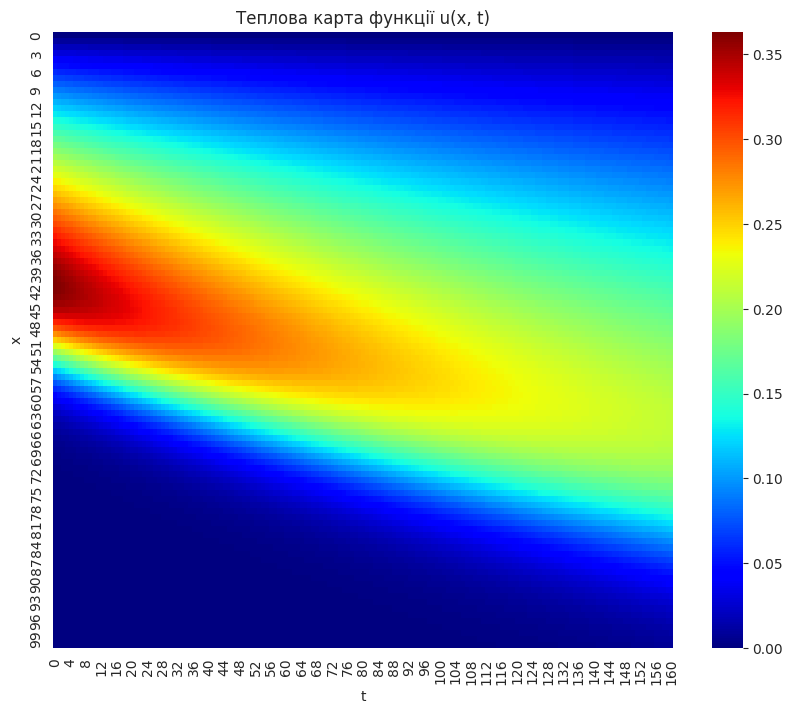

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(U_val, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()


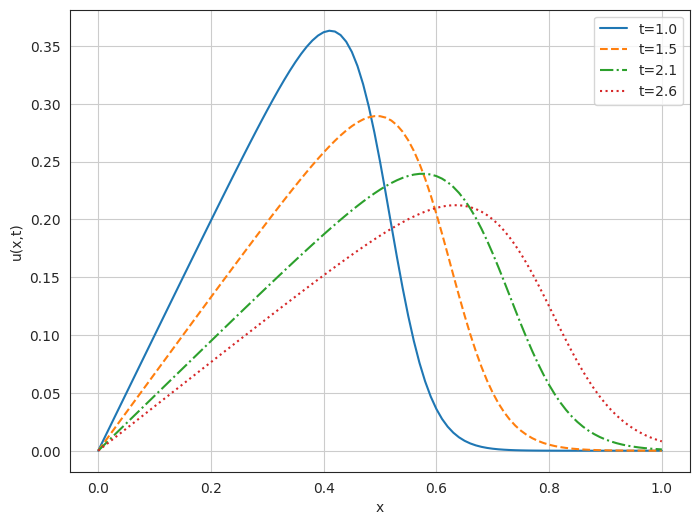

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x_val, U_val[:,0], label='t=1.0', linestyle='-')
plt.plot(x_val, U_val[:,50], label='t=1.5', linestyle='--')
plt.plot(x_val, U_val[:,110], label='t=2.1', linestyle='-.')
plt.plot(x_val, U_val[:,160], label='t=2.6', linestyle=':')

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


#Розв'язок засобами PINN

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 1
        self.t_max = 2.6

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        self.nu = 0.01
        self.epoch = 4000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        t0 = torch.exp(torch.tensor([1/(8*self.nu)]))

        y_ic  = ic[:,0] / (1 + torch.sqrt(1/t0)*torch.exp((ic[:,0]**2)/(4*self.nu)))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 6000,
            max_eval = 6000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

100 0.006302427966147661
0.00023390456044580787
0.00606852350756526
200 0.006006545387208462
0.0002580158179625869
0.005748529452830553
300 0.005522502586245537
0.00027445083833299577
0.005248051602393389
400 0.0042838454246521
0.00020774493168573827
0.004076100420206785
500 0.002763115568086505
0.00020659469009842724
0.0025565209798514843
600 0.002574631944298744
0.00023997662356123328
0.00233465526252985
700 0.0023531150072813034
0.00022217123478185385
0.0021309438161551952
800 0.0019656422082334757
0.0001972368045244366
0.0017684054328128695
900 0.0013660357799381018
0.00018821335106622428
0.0011778224725276232
1000 0.0007367540383711457
0.0002047576999757439
0.0005319963092915714
1100 0.0004756039415951818
0.00021313951583579183
0.00026246442575939
1200 0.0003566503874026239
0.00018486833141651005
0.00017178207053802907
1300 0.00028386019403114915
0.00015586875088047236
0.00012799142859876156
1400 0.00023500117822550237
0.00013569227303378284
9.930890519171953e-05
1500 0.0001978455

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [ ]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 2.5800],
        [1.0000, 2.5900],
        [1.0000, 2.6000]], device='cuda:0')

In [ ]:
X.shape

torch.Size([16261, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(101, 161)

In [ ]:
y_pred

array([[1.33889914e-03, 1.25488639e-03, 1.17528439e-03, ...,
        1.92672014e-05, 3.32891941e-05, 4.76539135e-05],
       [1.09410286e-02, 1.07640624e-02, 1.05932355e-02, ...,
        3.62792611e-03, 3.62762809e-03, 3.62782180e-03],
       [2.05685496e-02, 2.02980042e-02, 2.00351477e-02, ...,
        7.25044310e-03, 7.23567605e-03, 7.22132623e-03],
       ...,
       [3.45259905e-05, 2.13980675e-05, 1.04010105e-05, ...,
        5.15460968e-03, 5.40283322e-03, 5.65874577e-03],
       [3.16351652e-05, 1.88201666e-05, 8.28504562e-06, ...,
        3.75667214e-03, 3.95825505e-03, 4.16675210e-03],
       [2.37226486e-05, 1.13248825e-05, 1.25169754e-06, ...,
        2.61250138e-03, 2.77480483e-03, 2.94294953e-03]], dtype=float32)

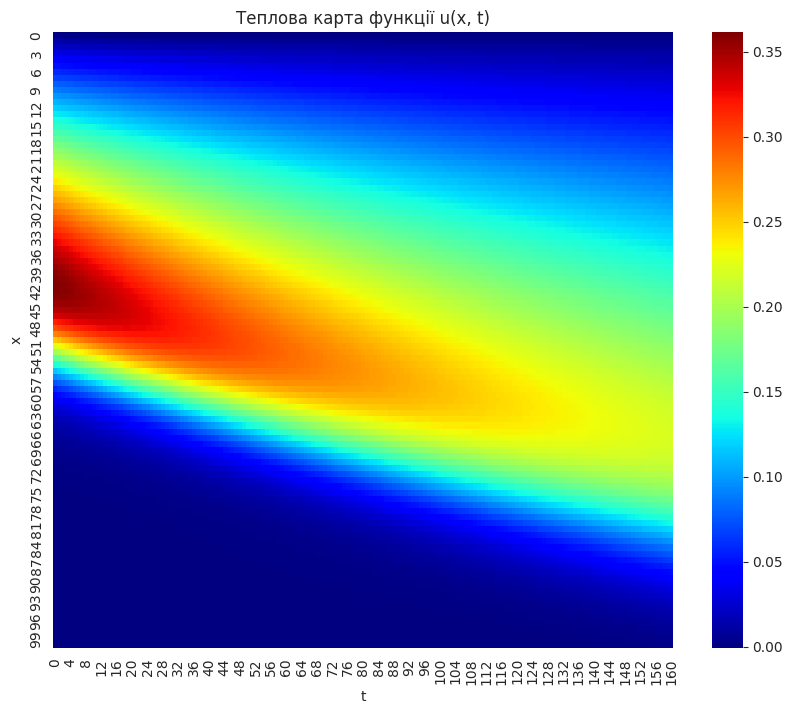

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



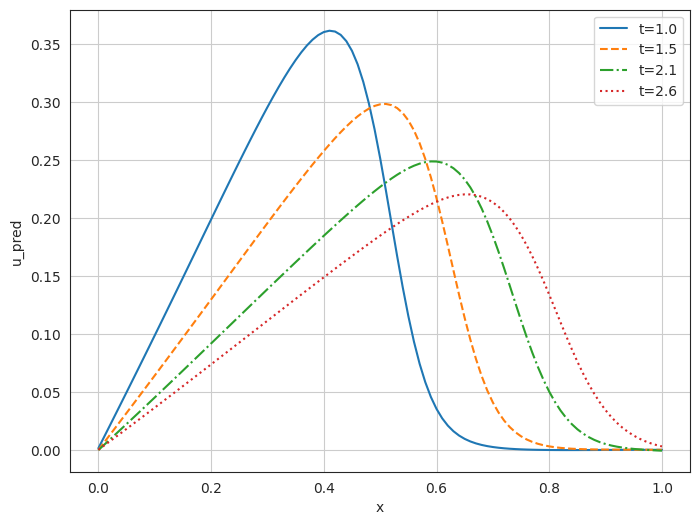

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x, y_pred[:,0], label='t=1.0', linestyle='-')
plt.plot(x, y_pred[:,50], label='t=1.5', linestyle='--')
plt.plot(x, y_pred[:,110], label='t=2.1', linestyle='-.')
plt.plot(x, y_pred[:,160], label='t=2.6', linestyle=':')

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u_pred')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


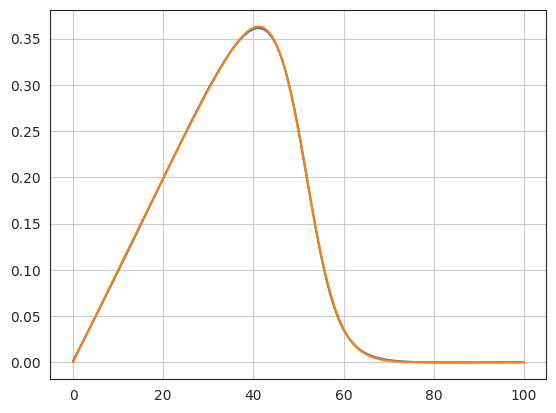

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(U_val[:,0])

plt.grid(True)
plt.show()

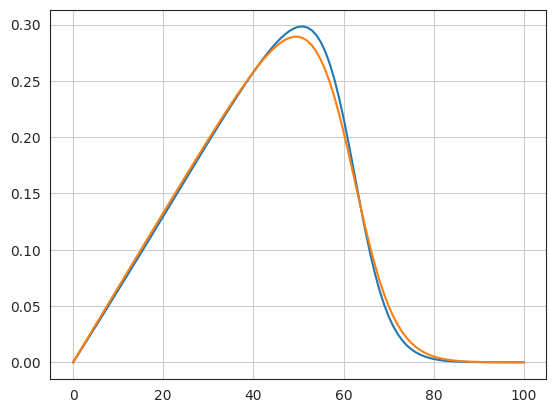

In [ ]:
plt.plot(y_pred[:,50])
plt.plot(U_val[:,50])

plt.grid(True)
plt.show()

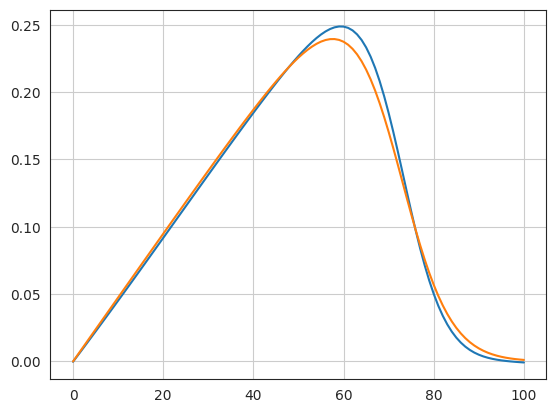

In [ ]:
plt.plot(y_pred[:,110])
plt.plot(U_val[:,110])

plt.grid(True)
plt.show()

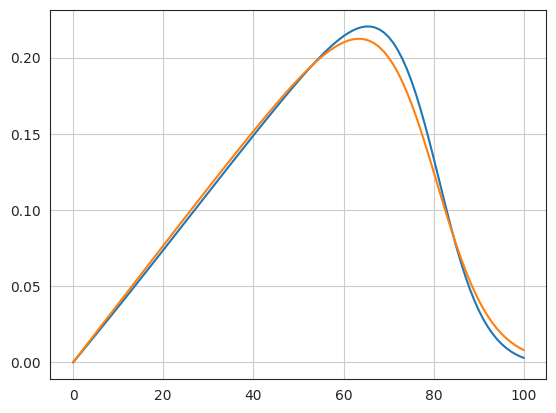

In [ ]:
plt.plot(y_pred[:,160])
plt.plot(U_val[:,160])

plt.grid(True)
plt.show()

In [ ]:
U_val.flatten().shape

(16261,)

In [ ]:
y_pred.flatten().shape

(16261,)

In [ ]:
from sklearn.metrics import r2_score

r2_score(U_val, y_pred)

0.995735156042376

#Обернена задача

In [ ]:
class Net_inv:
    def __init__(self, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.viscosity_coeff = 0.01
        lambda_value = 2.0
        print("the real value =",self.viscosity_coeff, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).float().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = 1
        self.t_max = 2.6

        # comp. domain
        self.h = 0.01
        self.k = 0.01

        self.epoch = 2000

        self.lambda_hist = []

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)




        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()

        print(self.X)

        # train data

        self.X_train = self.X

        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print(self.y_train)

        # breakpoint()

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        lambda_pde  = self.lambda_value

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - lambda_pde * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        self.lambda_hist.append(self.lambda_value.item())
        if self.iter % 100 == 0:

            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",self.viscosity_coeff,"IPINN lambda=", self.lambda_value.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
net_inv = Net_inv(y_pred)
net_inv.train()
net_inv.model.eval()

the real value = 0.01      Our I-PINNs value= 2.0
tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [1.0000, 2.5800],
        [1.0000, 2.5900],
        [1.0000, 2.6000]])
tensor([[0.0013],
        [0.0013],
        [0.0012],
        ...,
        [0.0026],
        [0.0028],
        [0.0029]])
iteration number = 100  loss value = 0.009340213611721992 real mu= 0.01 IPINN lambda= 1.9830738306045532
iteration number = 200  loss value = 0.009169365279376507 real mu= 0.01 IPINN lambda= 1.981567144393921
iteration number = 300  loss value = 0.009059443138539791 real mu= 0.01 IPINN lambda= 1.9795329570770264
iteration number = 400  loss value = 0.008950464427471161 real mu= 0.01 IPINN lambda= 1.9774070978164673
iteration number = 500  loss value = 0.00883492548018694 real mu= 0.01 IPINN lambda= 1.9754762649536133
iteration number = 600  loss value = 0.008709842339158058 real mu= 0.01 IPINN lambda= 1.9738471508026123
iteration number = 700  loss v

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net_inv.model
model.eval()
with torch.no_grad():
    y_pred_inv = model(X)
    y_pred_inv = y_pred_inv.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
print(net_inv.lambda_hist)

[2.0, 1.9989999532699585, 1.9980095624923706, 1.9970366954803467, 1.996090054512024, 1.995178461074829, 1.994310736656189, 1.9934942722320557, 1.9927349090576172, 1.9920361042022705, 1.9913986921310425, 1.9908207654953003, 1.9902983903884888, 1.9898260831832886, 1.9893975257873535, 1.9890062808990479, 1.9886465072631836, 1.98831307888031, 1.988002061843872, 1.9877104759216309, 1.987436294555664, 1.9871783256530762, 1.9869359731674194, 1.9867087602615356, 1.9864965677261353, 1.9862992763519287, 1.9861164093017578, 1.9859473705291748, 1.985791563987732, 1.9856479167938232, 1.9855154752731323, 1.9853930473327637, 1.9852794408798218, 1.9851737022399902, 1.985074758529663, 1.984981656074524, 1.9848939180374146, 1.9848108291625977, 1.9847321510314941, 1.984657645225525, 1.9845870733261108, 1.984520435333252, 1.9844576120376587, 1.9843984842300415, 1.9843429327011108, 1.9842908382415771, 1.9842419624328613, 1.9841960668563843, 1.9841527938842773, 1.9841119050979614, 1.9840731620788574, 1.9840

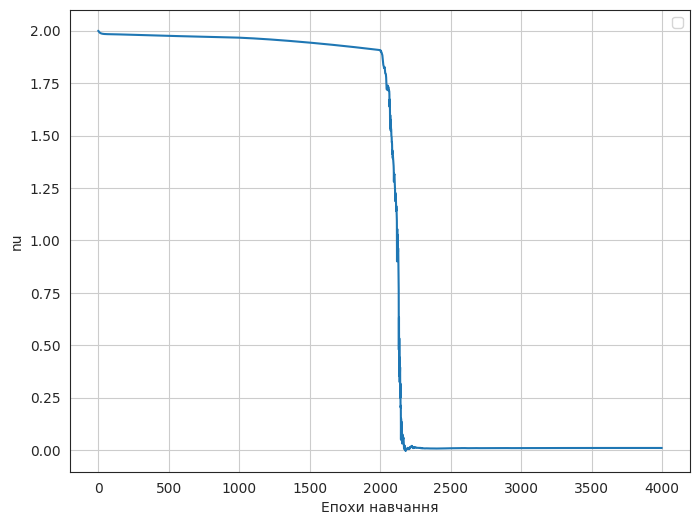

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('nu')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


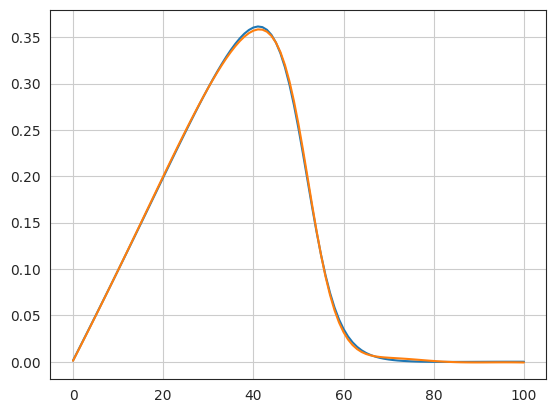

In [ ]:
plt.plot(y_pred[:,0])
plt.plot(y_pred_inv[:,0])

plt.grid(True)
plt.show()

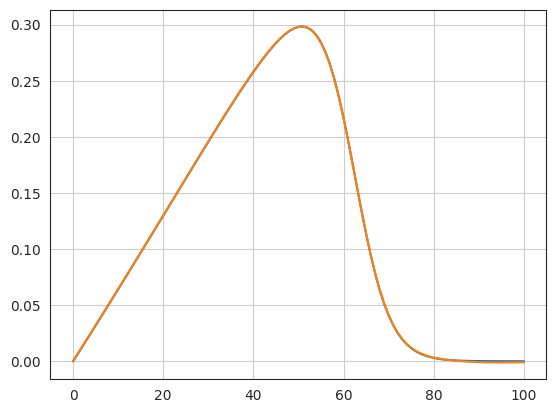

In [ ]:
plt.plot(y_pred[:,50])
plt.plot(y_pred_inv[:,50])

plt.grid(True)
plt.show()

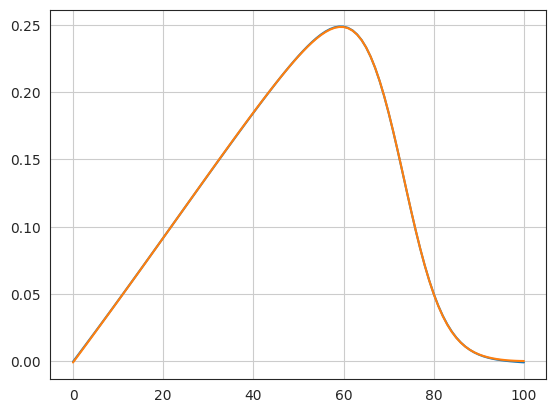

In [ ]:
plt.plot(y_pred[:,110])
plt.plot(y_pred_inv[:,110])

plt.grid(True)
plt.show()

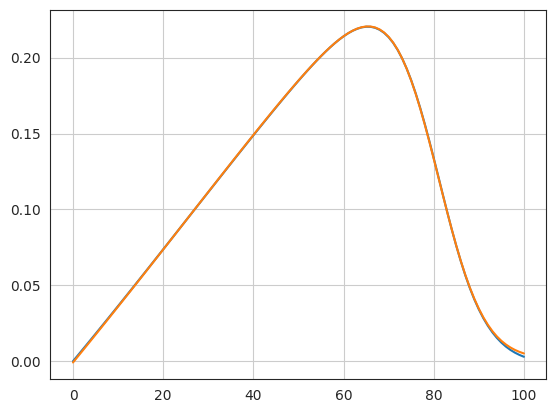

In [ ]:
plt.plot(y_pred[:,160])
plt.plot(y_pred_inv[:,160])

plt.grid(True)
plt.show()

In [ ]:
net.nu
net_inv.lambda_hist[-1]

0.009984660893678665

In [ ]:
(net.nu - net_inv.lambda_hist[-1])/net.nu*100

0.15339106321335047